## Imports

In [201]:
%load_ext autoreload
%autoreload 2

import os
import sys
# from napari_convpaint.conv_paint_utils import *
# from napari_convpaint.conv_paint_model import *
# from napari_convpaint.conv_paint_param import Param
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import napari
from skimage import morphology
import seaborn as sns
import pandas as pd
from aicsimageio import AICSImage

from CellAnalyzer import CellAnalyzer
import vetsuisse25_imaging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
>>> GPU activated? NO


In [120]:
virus = "MERS" # "229E" or "MERS"
in_path = "../imaging_data/21122022_images_jinglecells_SO_AK/" + virus

## Data loading and inspection

Create an object with the path to the data.

In [121]:
ca = CellAnalyzer(in_path)

>>> GPU activated? NO


Display the data table.

In [122]:
df, imgs = ca.read_data()
display(df)

7 images loaded


,condition,donor,time,date,sample,replicate,sample_id,mode1,mode2,filename,filepath
0,37mock,BEC5,48h,2021-12-22,00,1,BEC5_1,R3D,D3D,37mock_BEC5_48h_21.12.22_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
1,37mock,BEC5,48h,2021-12-22,01,2,BEC5_2,R3D,D3D,37mock_BEC5_48h_21.12.22.01_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
2,37mock,BEC5,48h,2021-12-22,03,3,BEC5_3,R3D,D3D,37mock_BEC5_48h_21.12.22.03_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
3,37mock,BEC6,48h,2021-12-22,00,1,BEC6_1,R3D,D3D,37mock_BEC6_48h_21.12.22_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
4,MERS,BEC5,48h,2021-12-22,00,1,BEC5_1,R3D,D3D,MERS_BEC5_48h_21.12.22_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
5,MERS,BEC5,48h,2021-12-23,00,2,BEC5_2,R3D,D3D,MERS_BEC5_48h_21.12.23_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
6,MERS,BEC6,48h,2021-12-22,01,1,BEC6_1,R3D,D3D,MERS_BEC6_48h_21.12.22.01_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...


Check dimensions.

In [123]:
imgs[0].shape

(4, 68, 960, 960)

Create projections.

In [124]:
projections = ca.create_projections(types=["max", "max", "max", "max"]) # Projection options: max, min, mean, median

In [125]:
print(ca.projections[0].shape)
print(ca.projections_types)

(4, 960, 960)
['max', 'max', 'max', 'max']


## Segmentation

In [126]:
masks, flows, styles, imgs_dn, outlines = ca.segment_cells(channels=[3,1]) # Channels for: Cytoplasm, Nucleus

In [127]:
# ca = CellAnalyzer.load(in_path + "/CellAnalyzer/CellAnalyzer.pkl")

Check to make sure the data was loaded correctly (hiding the irrelevant columns); after segmentation, the table now includes information about the IDs of the cells in each sample

In [128]:
ca.samples_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])

,condition,donor,replicate,sample_id,num_cells,cell_id_min,cell_id_max
0,37mock,BEC5,1,BEC5_1,343,1,343
1,37mock,BEC5,2,BEC5_2,306,344,649
2,37mock,BEC5,3,BEC5_3,331,650,980
3,37mock,BEC6,1,BEC6_1,359,981,1339
4,MERS,BEC5,1,BEC5_1,201,1340,1540
5,MERS,BEC5,2,BEC5_2,259,1541,1799
6,MERS,BEC6,1,BEC6_1,334,1800,2133


And we now also have a cells table, which contains the information about the sample plus cell-specific information

In [129]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df.iloc[1200:1205]

,condition,donor,replicate,sample_id,cell_id
1200,37mock,BEC6,1,BEC6_1,1201
1201,37mock,BEC6,1,BEC6_1,1202
1202,37mock,BEC6,1,BEC6_1,1203
1203,37mock,BEC6,1,BEC6_1,1204
1204,37mock,BEC6,1,BEC6_1,1205


Save segmentation results, just for viusalization purposes

In [130]:
# ca.save_segmentation_imgs(background_channels=[4,2])

Save the data

In [131]:
# ca.save(overwrite=True)

## Calculate Cell Signals

Mean, or alternatively Median

In [132]:
signals_mode = "mean"

In [133]:
ca.calculate_cell_signals({"cilia": 4, "inf": 2}, mode=signals_mode)

In [134]:
# ca = CellAnalyzer.load(in_path + "/CellAnalyzer/CellAnalyzer.pkl")

Check the new columns in the data table

In [135]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df.iloc[1200:1205]

,condition,donor,replicate,sample_id,cell_id,cilia_mean,cilia_mean_log10,inf_mean,inf_mean_log10
1200,37mock,BEC6,1,BEC6_1,1201,4685.717466,3.670776,663.558219,2.821879
1201,37mock,BEC6,1,BEC6_1,1202,5267.037348,3.721566,680.481707,2.832816
1202,37mock,BEC6,1,BEC6_1,1203,4266.040141,3.630025,667.770423,2.824627
1203,37mock,BEC6,1,BEC6_1,1204,4862.489869,3.686859,680.087798,2.832565
1204,37mock,BEC6,1,BEC6_1,1205,4480.508189,3.651327,664.789017,2.822684


We can also get the masks with the signals for each cell

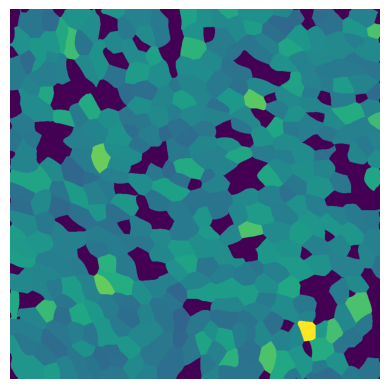

In [136]:
ex_signal_mask = ca.signals_masks["cilia"][3]
plt.imshow(ex_signal_mask)
plt.axis("off")
plt.show()

Save the data

In [137]:
# ca.save(overwrite=True)

## Define inf threshold and bin cells

In [138]:
# ca = CellAnalyzer.load(in_path + "/CellAnalyzer/CellAnalyzer.pkl")

### Infection

In [160]:
mock_inf_log10 = ca.cells_df[cells_df["condition"].str.contains("mock")]["inf_mean_log10"]
inf_log10_thresh = mock_inf_log10.mean() + 3 * mock_inf_log10.std()
inf_log10_thresh_low = mock_inf_log10.mean() + 1 * mock_inf_log10.std()
threshs = [inf_log10_thresh, inf_log10_thresh_low]
print(f"Inf log10 thresholds: {inf_log10_thresh_low} | {inf_log10_thresh}")

Inf log10 thresholds: 3.3048686427237315 | 3.886746802411588


In [161]:
ca.bin_cell_signal("inf", thresh=threshs)

In [162]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df[100:105]

,condition,donor,replicate,sample_id,cell_id,cilia_mean,cilia_mean_log10,inf_mean,inf_mean_log10,inf,cilia,population
100,37mock,BEC5,1,BEC5_1,101,8412.242499,3.924912,787.143876,2.896054,negative,positive,cil_pos_inf_neg
101,37mock,BEC5,1,BEC5_1,102,6998.027225,3.844976,738.749389,2.868497,negative,positive,cil_pos_inf_neg
102,37mock,BEC5,1,BEC5_1,103,8252.469059,3.916584,761.763201,2.881820,negative,positive,cil_pos_inf_neg
103,37mock,BEC5,1,BEC5_1,104,7182.439170,3.856272,734.362422,2.865910,negative,positive,cil_pos_inf_neg
104,37mock,BEC5,1,BEC5_1,105,5421.504120,3.734120,670.012118,2.826083,negative,positive,cil_pos_inf_neg


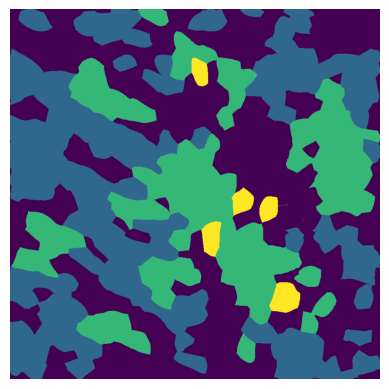

In [163]:
ex_bins_mask = ca.bin_masks["inf"][4]
plt.imshow(ex_bins_mask)
plt.axis("off")
plt.show()

In [164]:
virus_data = cells_df[cells_df["condition"].str.contains(virus)]

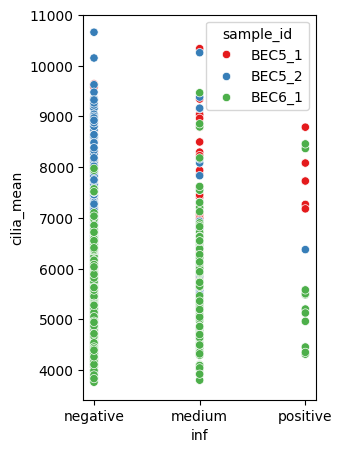

In [165]:
fig, ax = plt.subplots(figsize=(3, 5), dpi=100)
sns.scatterplot(data=virus_data, x='inf', y='cilia_'+signals_mode, palette="Set1", hue="sample_id", ax=ax)
plt.show()

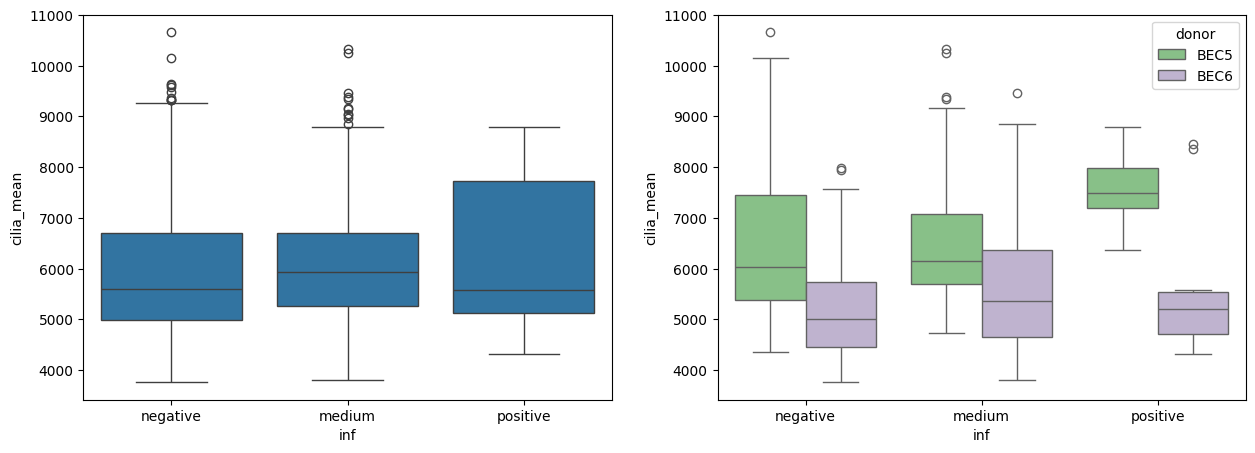

In [166]:
fig, ax = plt.subplots(1,2, figsize=(15, 5), dpi=100)
sns.boxplot(data=virus_data, x='inf', y='cilia_'+signals_mode, ax=ax[0])
sns.boxplot(data=virus_data, x='inf', y='cilia_'+signals_mode, ax=ax[1], palette="Accent", hue="donor")
plt.show()

### Cilia

In [167]:
ca.bin_cell_signal("cilia", thresh=None)

Using Otsu's method to find the threshold for cilia_mean_log10: 3.453369860261881


In [168]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df[100:105]

,condition,donor,replicate,sample_id,cell_id,cilia_mean,cilia_mean_log10,inf_mean,inf_mean_log10,inf,cilia,population
100,37mock,BEC5,1,BEC5_1,101,8412.242499,3.924912,787.143876,2.896054,negative,positive,cil_pos_inf_neg
101,37mock,BEC5,1,BEC5_1,102,6998.027225,3.844976,738.749389,2.868497,negative,positive,cil_pos_inf_neg
102,37mock,BEC5,1,BEC5_1,103,8252.469059,3.916584,761.763201,2.881820,negative,positive,cil_pos_inf_neg
103,37mock,BEC5,1,BEC5_1,104,7182.439170,3.856272,734.362422,2.865910,negative,positive,cil_pos_inf_neg
104,37mock,BEC5,1,BEC5_1,105,5421.504120,3.734120,670.012118,2.826083,negative,positive,cil_pos_inf_neg


In [169]:
virus_data = cells_df[cells_df["condition"].str.contains(virus)]

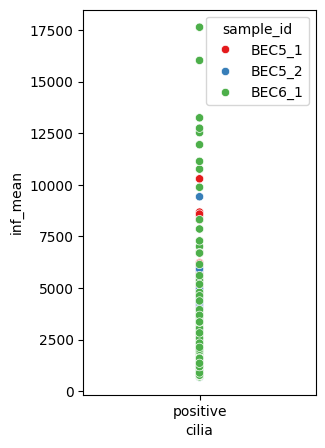

In [170]:
fig, ax = plt.subplots(figsize=(3, 5), dpi=100)
sns.scatterplot(data=virus_data, x='cilia', y='inf_'+signals_mode, palette="Set1", hue="sample_id", ax=ax)
plt.show()

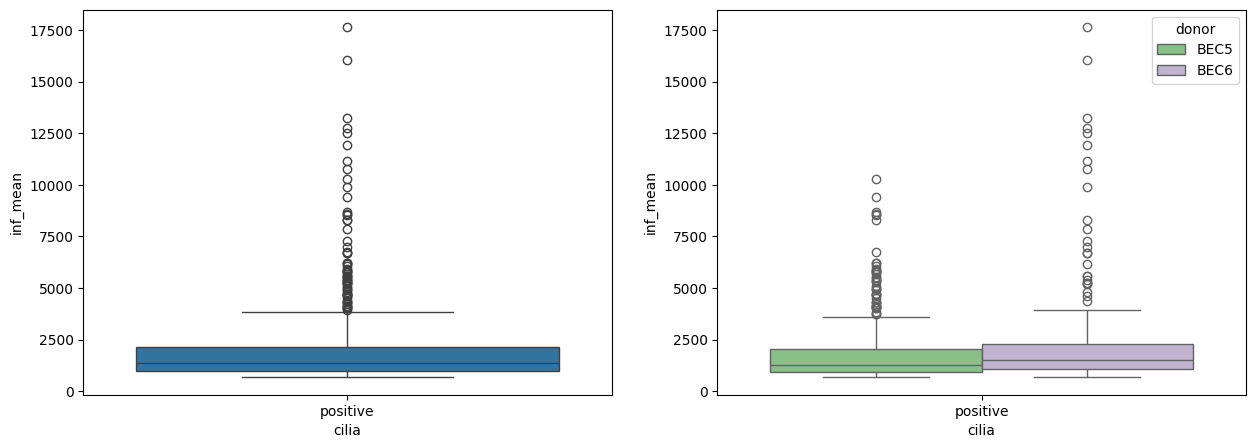

In [171]:
fig, ax = plt.subplots(1,2, figsize=(15, 5), dpi=100)
sns.boxplot(data=virus_data, x='cilia', y='inf_'+signals_mode, ax=ax[0])
sns.boxplot(data=virus_data, x='cilia', y='inf_'+signals_mode, ax=ax[1], palette="Accent", hue="donor")
plt.show()

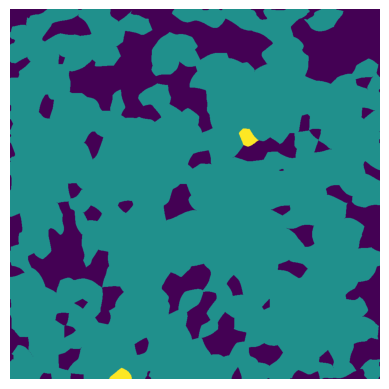

In [179]:
ex_bins_mask = ca.bin_masks["cilia"][1]
plt.imshow(ex_bins_mask)
plt.axis("off")
plt.show()

### Combined

In [ ]:
sns.heatmap(ca.cells_df.pivot_table())

### Save the data

In [173]:
# ca.save(overwrite=True)

## Extract the populations (combinations of inf and cilia)

In [174]:
ca.create_populations("cilia", "inf")

In [212]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df[100:105]

,condition,donor,replicate,sample_id,cilia_mean,cilia_mean_log10,inf_mean,inf_mean_log10,inf,cilia,population
cell_id,,,,,,,,,,,
101,37mock,BEC5,1,BEC5_1,8412.242499,3.924912,787.143876,2.896054,negative,positive,cil_pos_inf_neg
102,37mock,BEC5,1,BEC5_1,6998.027225,3.844976,738.749389,2.868497,negative,positive,cil_pos_inf_neg
103,37mock,BEC5,1,BEC5_1,8252.469059,3.916584,761.763201,2.881820,negative,positive,cil_pos_inf_neg
104,37mock,BEC5,1,BEC5_1,7182.439170,3.856272,734.362422,2.865910,negative,positive,cil_pos_inf_neg
105,37mock,BEC5,1,BEC5_1,5421.504120,3.734120,670.012118,2.826083,negative,positive,cil_pos_inf_neg


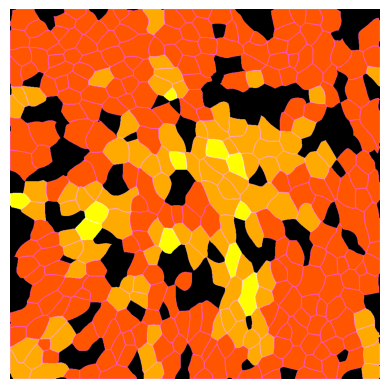

In [176]:
ex_pop_img = ca.pop_imgs[6]
plt.imshow(ex_pop_img)
plt.axis("off")
plt.show()

Save the data

In [232]:
ca.save(overwrite=True)